# Using vaex to process tick data

January 2021 - Saeed Amen - https://www.cuemacro.com - saeed@cuemacro.com

## Introduction

In this Jupyter notebook, we discuss how to use the vaex library to process high frequency time series data, which in our example is FX tick data. Our main aim is to show how vaex can be a good library to do such computations.

### Python libraries to try

There are several ways to work with time series tick data in Python. Here are a few possible ideas below. Note it isn't an exhaustive list, and there are lots of other time series style libraries including modin etc.

* [Pandas](https://github.com/pandas-dev/pandas) - This is the most popular time series library and I use it a lot! However, when your datasets are very large you need to batch your calculations
* [Dask](https://github.com/dask/dask) - This is a library for parallel computing with task scheduling. It has Dask DataFrames which look like Pandas DataFrames to the user, but they can be much bigger than memory, and underneath Dask handles all the batching and construction of a graph for computation for us
* [NumPy](https://github.com/numpy/numpy) - It's main library for working with arrays in Python. Whilst, it isn't designed purely for time series, we can use NumPy arrays to represent time series, and computations can be quickly using pure NumPy than Pandas.
* [TensorFlow](https://github.com/tensorflow/tensorflow) - Whilst TensorFlow is primarily a library for machine learning, the newest version has an NumPy like interface, to make it easy to use it instead of NumPy. It can also target the GPU.

There are all sorts of tips and tricks we can use to speed up Python and the tools above, without having to resort to rewriting all our Python in another faster language like C. We can for example use [Numba](http://numba.pydata.org/) to speed up lots of numerical calculations (targeting either CPU or GPU) or [Cython](https://cython.org/). I tend to like using Numba and it's a great tool, although it does often require some rewriting of your code. The trick is to identify the particular bottlenecks in your code, and spend time there too. 

### Run across more cores or on the cloud

We can also try to run our code in more cores. I've used Celery, in [tcapy](https://www.github.com/cuemacro) to distribute computation with tick data to more cores (or it can be setup to compute across multiple machines). Dask also allows you to set up clusters for computation. However, ultimately if we are doing this locally, we are likely to face limits in the amount of CPU and memory we have.

With the cloud, this type of scaling becomes easier. You can use tools serverless compute, such as with [AWS Lambdas](https://aws.amazon.com/lambda/), which abstract away some of the complexity of managing multiple machines. [Coiled](https://coiled.io/) is a service which allows you to easily run Dask clusters in the cloud.

Alternatively, rather than relying on Python to do a lot of our numerical computations, we can use time series databases. They can do the computations inside them, doing the heavy lifting for us, and then return results to Python. These databases could for example include kdb+/q which is specifically designed for tick data, we'll hopefully talk about them at another time!

## So what's vaex?

Like Dask, vaex is a Python based library that allows us to do computations on datasets that are too big to fit in memory. You can use vaex to query data in a Pythonic way, similar to how you use Pandas or Dask. Hence, we don't need to learn any different database query languages (e.g. like q or k). It should be noted that the vaex API is slightly different to pandas API calls.

Vaex can load up data in Arrow format. Arrow is an open source format for storing columnar data, in an efficient way. Just like with kdb+/q, Vaex won't try to load up your dataset from disk. Instead, it is smart about which sections to read/write. Like kdb+/q, vaex memory maps the dataset from disk. However, vaex is all open source unlike kdb+/q and it's also easier to query vaex, if you are used to Python. If we want to query kdb+/q we'll have to learn q. 

[An article from AquaQ](https://www.aquaq.co.uk/q/comparing-columnar-data-formats-arrow-vaex-and-kdb/) compares kdb+/q with vaex in more detail and also has some benchmarks. [This article](https://towardsdatascience.com/vaex-a-dataframe-with-super-strings-789b92e8d861)  also introduces vaex with a focus on how it can speed up string operations.

## Download and prepare some tick data

First thing we need to do is to get some tick data. I've used my tcapy library to download a large amount of FX tick data from Dukascopy. We outline the scripts we've used below. To use them you'll need to install tcapy fully on your machine. You'll also likely need to change some of the folders in the scripts.

* [dump_data_vendor_to_parquet_csv_hdf5.py](https://github.com/cuemacro/tcapy/blob/master/tcapy_scripts/gen/dump_data_vendor_to_parquet_csv_hdf5.py) - This downloads the tick data from Dukascopy, and then dumps the data as Parquet files at a monthly frequency
* [copy_parquet_to_arrow.py](https://github.com/cuemacro/tcapy/blob/master/tcapy_scripts/gen/copy_parquet_to_arrow.py) - This converts Parquet files into Arrow files and places them into a different folder. Vaex can work with Parquet files, but there's generally more support in terms of functionality for Arrow files. In particualr for Arrow files it has lazy loading.

Let's assume we've run the above files (and note that it would likely take a few days to download the data at least). We should have files that look like this, with the currency pair (`AUDUSD`), the data source (`dukascopy`), the start date/time and end date/time of that month.
* `parquet folder - eg. AUDUSD_dukascopy_2021-01-03_22_00_00.202000+00_002021-01-31_23_59_54.269000+00_00.parquet`
* `arrow_folder - eg. AUDUSD_dukascopy_2021-01-03_22_00_00.202000+00_002021-01-31_23_59_54.269000+00_00.arrow`

## Analysing the tick data

To start with let's do some imports of libraries and define paths that we'll use later.

In [3]:
import pandas as pd
import dask
import dask.dataframe as dd
import vaex
import concurrent

arrow_folder = "e:/Datasets/csv_dump/dukascopy_arrow/"
parquet_folder = "e:/Datasets/csv_dump/dukascopy_parquet/"

In [5]:
import numpy as np
np.__version__

'1.19.1'

### Using vaex to calculate the average spread by day

First, we load up the data. As mentioned before, vaex doesn't actually load all of it up into memory, so the "load" step is actually quite fast. This would be in contrast to using something like Pandas, where the whole file we're working on needs to be loaded up into memory.

The next step is to calculate the bid/ask spread and then to calculate the average spread by date. Finally, we convert the output from a vaex DataFrame into a pandas DataFrame. My benchmark machine is running Windows with a Intel Core i9-7940X CPU 3.1 GHz with 14 cores, 128 GB RAM and a 2 TB Samsung 970 Evo Plus m.2 SSD.

On this machine, the computation takes just over 10 seconds. Our dataset consists of EURUSD tick data and our sample on disk is from 2005-2021.

In [2]:
%%time
df_v = vaex.open(arrow_folder + "EURUSD*.arrow")

# Calculate the spread and then bucket average by date
df_v.spread_bp = 10000 * (df_v.ask - df_v.bid) / df_v.mid
df_v_daily_spread = df_v.groupby(by=vaex.BinnerTime(df_v.Date, resolution='D'), 
                                 agg={'spread_bp': vaex.agg.mean(df_v.spread_bp)})

# Convert to pandas DataFrame and remove any Sat/Sun values
df_pd_daily_spread = df_v_daily_spread.to_pandas_df()
df_pd_daily_spread = df_pd_daily_spread.set_index('Date')

df_pd_daily_spread = df_pd_daily_spread[df_pd_daily_spread.index.dayofweek < 5]

ERROR:MainThread:vaex:error opening 'e:/Datasets/csv_dump/dukascopy_arrow/EURUSD*.arrow'


OSError: File pattern did not match anything e:/Datasets/csv_dump/dukascopy_arrow/EURUSD*.arrow

Let's plot the output of the spread. It's likely that some of the spikes might not be real (ie. related to holidays like New Years Day, when FX market is actually closed).

<AxesSubplot:xlabel='Date'>

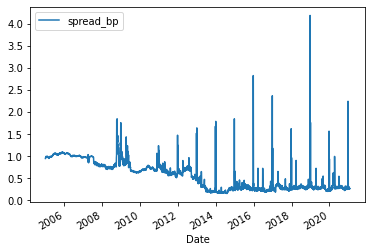

In [3]:
%matplotlib inline

df_pd_daily_spread.plot()

### Using Dask to calculate the spread by day

Let's try doing a similar computation with Dask. To set up the problem takes very little time, because Dask is doing lazy evaluation. It won't actually do the computation till it really needs to do so. Underneath it uses a threaded scheduler to execute the batches. You can also use a more heavy weight scheduler based on multiproccessing or a cluster, that can be run on multiple machine. Note, that because NumPy and Pandas release the GIL, even using a threaded scheduler might give you a speed up. In practice, both Vaex and NumPy tend to release the GIL on more operations than Pandas.

In this case, we are using the tick data stored in Parquet files with Dask, given it doesn't handle Arrow format. Again, we are using EURUSD tick data between 2005-2021.

In [4]:
%%time
df_dd = dd.read_parquet(parquet_folder + "EURUSD*.parquet")

df_dd.spread_bp = 10000 * (df_dd.ask - df_dd.bid) / df_dd.mid

df_dd_daily_spread = df_dd.spread_bp.groupby(df_dd.index.dt.date).mean()

Wall time: 1.24 s


The next step will be quite slow, because it will actually kick off the computation. On my machine it takes around 5 minutes.. much slower than vaex!

In [5]:
%%time

df_dd_pd_daily_spread = df_dd_daily_spread.compute()

Wall time: 5min 14s


In [6]:
df_dd_pd_daily_spread.index = pd.to_datetime(df_dd_pd_daily_spread.index)
df_dd_pd_daily_spread = df_dd_pd_daily_spread[df_dd_pd_daily_spread.index.dayofweek < 5]

<AxesSubplot:>

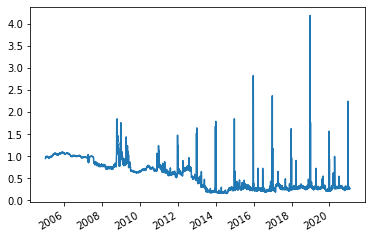

In [7]:
%matplotlib inline

df_dd_pd_daily_spread.plot()

## Conclusion

We've taken a quick look at a simple computation involving tick data both using vaex and Dask. At least in this example, it does appear that vaex is much quicker (just over 10 seconds versus nearly 4 minutes with Dask) and it definitely warrants more investigation!

What are the downsides of vaex? Probably the main one is that the API looks slightly different to Pandas. Whereas Dask's DataFrame API is closer to vaex. That being said, you do get used to the nuances of vaex. Vaex is also a newer library than Dask, but I expect over time its feature set will expand and the feature gap between the two libraries will reduce.